# <u>Machine Learning Engineer Nanodegree</u>  
## Capstone Project: Stock Price Prediction with Deep Learning Models
Masaharu KINOSHITA  
e-mail: <k.masaharu0219@gmail.com>  
LinkedIn: [masaharu kinoshita](https://www.linkedin.com/in/masaharu-kinoshita/) *I prefer linkedin for communication with you.  
Apr, 2019  
project specifications: [review points](https://review.udacity.com/#!/rubrics/108/view)

## <u>Agenda</u>
**#1. Definition** ------- How do I establish this Problem?  
**#2. Analysis** -------- How do I define problem solving and design my approach?  
**#3. Methodology** -- How do I conduct this approach in terms of data science?  
**#4. Results** -------- What do my approach result in?  
**#5. Conclusions**

---
## <u>#1. Definition</u>
### 1-1. Project Overview:
In this proposal, in order to verify how useful CNN is to solve time-series prediction problem, CNN, LSTM, and CNN+LSTM are build on stock datasets of Google obtained at kaggle. As you know, CNN is mainly used in the field of Image Recognition so far. CNN, however, has recently been said to be a valid method to solve time-series forecasting problem. In order to show that RNN, LSTM, and CNN+LSTM models are build on the google stock datasets and their score on the test datasets are compared with benchmark score of RNN, which is often used for time-series data, with MSE.  

### 1-2. Problem Statement: 
In this proposal, usability of deep learning, especially CNN as an feature extractor, is verified. Although CNN is known to be valid in the field of Image Recognition, few use-case of CNN are applied to finance problem, such as stock price predictions. This is because a lot of Algorithm Trading has employed technical index so far. These index, however, are commonly used and developed by humans. So, it can be said that there is some room to improve Trading Algorithm.  
In this context, applying CNN to the finance problem and validation of its usefulness is meaningful as CNN has high potential to recognize patterns in given dataset and computational power has advanced so far.  
In order to valid the usefulness of LSTM and CNN+LSTM are compared to the stock price predictions with metrics MSE. In addition to this, RNN is set as base-models. By comparing the four models with MSE, the usefulness of CNN are verified in the stock price problem.  

### 1-3. Metrics: 
As mentioned above, MSE is evaluation metrics. Needless to say, less MSE is better for stock price prediction. The reasons of employing MSE in this problem are the followings.  
First, the target value, which is daily close stock price, is continuous. So, this is regression problem.  
Second, more penalty is added to larger error with MSE compared to MAE by employing squared value.  
Therefore, MSE is employed as evaluation metrics.

---
## <u>#2. Analysis</u>

In [232]:
# import libraries
import os
import time
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display as p
%matplotlib inline
warnings.filterwarnings('ignore')
base_path = os.getcwd()

### 2-1. Data Exploration
In this problem, google stock price datasets obtained [kaggle](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) are used. Stock datasets from 2014-03-27 to 2017-05-01 are used as train datasets. Stock datasets from 2017-05-01 to 2017-11-10 are used as test datasets.  
**1. train.csv**  
- number of rows: 780
- number of columns: 6  

**2. test.csv**  
- number of rows: 137
- number of columns: 6

**3. columns and data types**
- Date: date, index
- Open: float
- High: float
- Low: float
- Volume: float
- Close: float, target

In [185]:
# load stock datasets of google
## set file names:
train_name = 'train.csv'
test_name = 'test.csv'

## read data:
df_train = pd.read_csv(os.path.join(base_path,'input', train_name))
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.set_index('Date')
df_test = pd.read_csv(os.path.join(base_path, 'input', test_name))
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test.set_index('Date')

## shapes of train and test datasets:
print('Train datasets: ', df_train.shape)
print('Test datasets: ', df_test.shape)

y_train, y_test = df_train['Close'], df_test['Close']
X_train, X_test = df_train.drop('Close', axis=1), df_test.drop('Close', axis=1)

## data types of datasets: 
print('---'*25)
print('dtypes of datasets: ')
print(df_train.info())

## heads of train and test datasets:
print('---'*25)
print('Train datasets:')
p(df_train.head())
print('Test datasets: ')
p(df_test.head())

## basic statistic info of datasets:
print('---'*25)
print('basic statistic of datasets: ')
print(X_train.describe())

Train datasets:  (780, 5)
Test datasets:  (137, 5)
---------------------------------------------------------------------------
dtypes of datasets: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 2014-03-27 to 2017-05-01
Data columns (total 5 columns):
Open      780 non-null float64
High      780 non-null float64
Low       780 non-null float64
Close     780 non-null float64
Volume    780 non-null int64
dtypes: float64(4), int64(1)
memory usage: 36.6 KB
None
---------------------------------------------------------------------------
Train datasets:


,Open,High,Low,Close,Volume
Date,,,,,
2014-03-27,568.00,568.00,552.92,558.46,13052
2014-03-28,561.20,566.43,558.67,559.99,41003
2014-03-31,566.89,567.00,556.93,556.97,10772
2014-04-01,558.71,568.45,558.71,567.16,7932
2014-04-02,599.99,604.83,562.19,567.00,146697


Test datasets: 


,Open,High,Low,Close,Volume
Date,,,,,
2017-05-01,901.94,915.68,901.450,912.57,2115701
2017-05-02,909.62,920.77,909.453,916.44,1545245
2017-05-03,914.86,928.10,912.543,927.04,1498051
2017-05-04,926.07,935.93,924.590,931.66,1421984
2017-05-05,933.54,934.90,925.200,927.13,1911275


---------------------------------------------------------------------------
basic statistic of datasets: 
             Open        High         Low        Volume
count  780.000000  780.000000  780.000000  7.800000e+02
mean   659.798927  664.838887  654.095332  1.762739e+06
std    108.205845  108.556833  108.148483  9.887431e+05
min    494.650000  495.980000  487.560000  7.932000e+03
25%    550.000000  554.580000  544.177500  1.192554e+06
50%    660.105000  664.985000  653.235000  1.552158e+06
75%    757.755000  765.305000  750.522750  2.050637e+06
max    910.660000  916.850000  905.770000  1.116490e+07


### 2-2. Exploratory Visualization
In this section, the Close Price of train and test datasets, which is target value, are visualized. As shown below, the Close price of google are increasing from 2014-03-27 to 2017-11-10. 

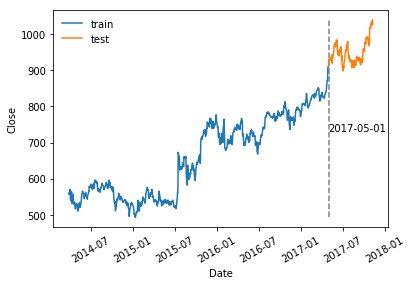

In [195]:
# visualization of train and test target datasets
plt.plot(X_train.index, y_train, label='train')
plt.plot(X_test.index, y_test, label='test')

plt.vlines(X_train.index.max(), ymin=y_train.min(), ymax=y_test.max(), linestyles='--', colors='gray')
plt.text(X_train.index.max(), y_train.max()*4/5, X_train.index.max().strftime('%Y-%m-%d'), fontsize=10)
plt.xlabel('Date'); plt.ylabel('Close'); plt.title('The Close Price of Google from 2014-03-27 to 2017-11-10')
plt.xticks(rotation=30)
plt.legend(loc='best', frameon=False)
plt.savefig('./img/'+'close_price_plot.png')
plt.show()

### 2-3. Algorithms and Techniques
In this paper, deep learning models performing well for time-series predictions, RNN, LSTM, CNN+LSTM, are used because the Close Price are relevant with the past stock information, which is our input data such as Open, High, Low, Volume columns. By applying RNN, LSTM, CNN+LSTM models to this time-series forecasting problem, how useful CNN is to solve time-series prediction problem is verified. 

### 2-4. Benchmark
In this problem, RNN model is build to get base MSE as benchmark model. RNN, one of the famous deep learning models, is often used for time-series forecasting. This is an usual score with conventional method employing deep learning. As mentioned above, the metrics with which the benchmark model is measured is also MSE.

---
# <u>#3. Methodology</u>
### 3-1. Data Preprocessing
In this section, preprocessing datasets, especially normalization, is explained. In this problem, the datasets are normalized within window datasets.  
More concretely speaking, window datasets values are devided by the value of its first index, 0. After do that, the values devided are minus 1 in order to set the value range from -1.0 to 1.0. This noramlization allows my deep learning models to learn more first and get properly regularization term effect. Actually, in this paper, no regularization approch are employed because this don't meet my goal which is to verify CNN potential for time-series forecasting.  
In this time, 10 is employed for the window length. 

In [233]:
# preprocessing: normalization
## set window size
window = 10

## train data noromalization
X_train_scls, y_train_scls= [], []
for i in range(X_train.shape[0] - window):
    X_tmp = X_train.iloc[i:i+window].copy()
    # normalized by first day in its window and minus 1 in order to set the value range at [-1., 1.]
    X_tmp = X_tmp/X_tmp.iloc[0] - 1
    X_train_scls.append(X_tmp)

## test data noromalization
X_test_scls, y_test_scls= [], []
for i in range(X_test.shape[0] - window):
    X_tmp = X_test.iloc[i:i+window].copy()
    # normalized by first day in its window and minus 1 in order to set the value range at [-1., 1.]
    X_tmp = X_tmp/X_tmp.iloc[0] - 1
    X_test_scls.append(X_tmp)

X_train_fin = np.array([np.array(X_train_scl) for X_train_scl in X_train_scls])
y_train_fin = (y_train[window:].values / y_train[:-window].values) - 1

X_test_fin = np.array([np.array(X_test_scl) for X_test_scl in X_test_scls])
y_test_fin = (y_test[window:].values / y_test[:-window].values) - 1
print('X_train shape: ', X_train_fin.shape)
print('y_train shape: ', y_train_fin.shape)

X_train shape:  (770, 10, 4)
y_train shape:  (770,)


### 3-2. Implementation
The process for which metrics, algorithms, and techniques were implemented with the given datasets or input data has been thoroughly documented.  
As for metics, MSE are employed in order to give more penalty on larger error compared to MAE because it is squared value. 

As for algorithms and techniques, deep learning models are selected to perform well on this time-series problem. As mentioned above, RNN is employed as benchmark model. It is widely used for time-series prediction problem. According the convention, deep learning model with 6 RNN layers and 1 Dence is epmployed as benchmark model and trained on those datasets. But, it reaches the limit at 0.00169 MSE.  

### 3-3. Refinement
So, LSTM which has capability to learn logn-term dependencies are employed as second deep leanring model. LSTM performs better than RNN and it achieves xxx MSE in comparision with 0
So, CNN+LSTM 

In [289]:
# build model
from keras.models import Sequential
from keras.layers import Conv1D, RNN, SimpleRNN, LSTM, Dense, Dropout, MaxPooling1D, InputLayer, GlobalMaxPool1D

## set parameters
step_size = 10
input_size = 4
num_epochs = 40

## benchmark model; RNN 
def build_rnn(input_shape=(step_size, input_size), loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(16, input_shape=(step_size, input_size), return_sequences=True))
    model.add(SimpleRNN(16, input_shape=(step_size, input_size), return_sequences=True))
    model.add(SimpleRNN(16, input_shape=(step_size, input_size), return_sequences=True))
    model.add(SimpleRNN(16, input_shape=(step_size, input_size), return_sequences=True))
    model.add(SimpleRNN(16, input_shape=(step_size, input_size), return_sequences=True))
    model.add(SimpleRNN(16, input_shape=(step_size, input_size), return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    print('---'*25)
    print('rnn architecture: ')
    print(model.summary())
    print('\n')
    return model

## LSTM
def build_lstm(input_shape=(step_size, input_size), loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(16, input_shape=(step_size, input_size), return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(LSTM(16, return_sequences=True))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    print('---'*25)
    print('lstm architecture: ')
    print(model.summary())
    print('\n')
    return model

## CNN+LSTM
def build_cnn_lstm(input_shape=(step_size, input_size), loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(3))
#     model.add(Dropout(.5))
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(3))
#     model.add(Dropout(.4))
    model.add(LSTM(16, recurrent_dropout=.5, return_sequences=True))
    model.add(LSTM(16, recurrent_dropout=.4, return_sequences=True))
    model.add(LSTM(16, recurrent_dropout=.3, return_sequences=True))
    model.add(LSTM(16, recurrent_dropout=.2, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    print('---'*25)
    print('cnn+lstm architecture: ')
    print(model.summary())
    print('\n')
    return model

In [290]:
# compile RNN
rnn = build_rnn(input_shape=(step_size, input_size))

# compile LSTM
lstm = build_lstm(input_shape=(step_size, input_size))

# compile CNN+LSTM
cnn_lstm = build_cnn_lstm(input_shape=(step_size, input_size))

---------------------------------------------------------------------------
rnn architecture: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_261 (SimpleRNN)   (None, 10, 16)            336       
_________________________________________________________________
simple_rnn_262 (SimpleRNN)   (None, 10, 16)            528       
_________________________________________________________________
simple_rnn_263 (SimpleRNN)   (None, 10, 16)            528       
_________________________________________________________________
simple_rnn_264 (SimpleRNN)   (None, 10, 16)            528       
_________________________________________________________________
simple_rnn_265 (SimpleRNN)   (None, 10, 16)            528       
_________________________________________________________________
simple_rnn_266 (SimpleRNN)   (None, 16)                528       
_______________________________________________

In [291]:
# deep learning models training: 
## RNN trianing:
print('RNN training...')
start = time.time()
hist_rnn = rnn.fit(X_train_fin, y_train_fin, epochs=num_epochs, validation_data=(X_test_fin, y_test_fin))
elapsed_time_rnn = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time_rnn) + "[sec]")
print('\n')

## LSTM trianing:
print('LSTM training...')
start = time.time()
hist_lstm = lstm.fit(X_train_fin, y_train_fin, epochs=num_epochs, validation_data=(X_test_fin, y_test_fin))
elapsed_time_lstm = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time_lstm) + "[sec]")
print('\n')

## CNN+LSTM trianing:
print('CNN+LSTM training...')
start = time.time()
hist_cnn_lstm = cnn_lstm.fit(X_train_fin, y_train_fin, epochs=num_epochs, validation_data=(X_test_fin, y_test_fin))
elapsed_time_cnn_lstm = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time_cnn_lstm) + "[sec]")

RNN training...
Train on 770 samples, validate on 127 samples
Epoch 1/40
770/770 [==============================] - 96s 125ms/step - loss: 0.0758 - mean_absolute_error: 0.1970 - val_loss: 0.0212 - val_mean_absolute_error: 0.1187
Epoch 2/40
770/770 [==============================] - 1s 1ms/step - loss: 0.0208 - mean_absolute_error: 0.1013 - val_loss: 0.0134 - val_mean_absolute_error: 0.0783
Epoch 3/40
770/770 [==============================] - 1s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0751 - val_loss: 0.0080 - val_mean_absolute_error: 0.0683
Epoch 4/40
770/770 [==============================] - 1s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0605 - val_loss: 0.0055 - val_mean_absolute_error: 0.0541
Epoch 5/40
770/770 [==============================] - 1s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0540 - val_loss: 0.0054 - val_mean_absolute_error: 0.0555
Epoch 6/40
770/770 [==============================] - 1s 1ms/step - loss: 0.0049 - mean_absolute_error: 0.0513 - va

770/770 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0259 - val_loss: 7.0472e-04 - val_mean_absolute_error: 0.0224
Epoch 10/40
770/770 [==============================] - 2s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0256 - val_loss: 6.5271e-04 - val_mean_absolute_error: 0.0214
Epoch 11/40
770/770 [==============================] - 2s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0248 - val_loss: 5.8320e-04 - val_mean_absolute_error: 0.0200
Epoch 12/40
770/770 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0240 - val_loss: 5.6682e-04 - val_mean_absolute_error: 0.0199
Epoch 13/40
770/770 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0232 - val_loss: 4.7424e-04 - val_mean_absolute_error: 0.0178
Epoch 14/40
770/770 [==============================] - 2s 3ms/step - loss: 9.4476e-04 - mean_absolute_error: 0.0219 - val_loss: 4.7416e-04 - val_mean_absolute_error: 0

770/770 [==============================] - 1s 1ms/step - loss: 4.8281e-04 - mean_absolute_error: 0.0166 - val_loss: 3.1970e-04 - val_mean_absolute_error: 0.0142
Epoch 17/40
770/770 [==============================] - 1s 1ms/step - loss: 4.8522e-04 - mean_absolute_error: 0.0167 - val_loss: 3.0561e-04 - val_mean_absolute_error: 0.0140
Epoch 18/40
770/770 [==============================] - 1s 1ms/step - loss: 4.3345e-04 - mean_absolute_error: 0.0157 - val_loss: 3.1681e-04 - val_mean_absolute_error: 0.0145
Epoch 19/40
770/770 [==============================] - 1s 1ms/step - loss: 4.2281e-04 - mean_absolute_error: 0.0156 - val_loss: 2.8256e-04 - val_mean_absolute_error: 0.0135
Epoch 20/40
770/770 [==============================] - 1s 1ms/step - loss: 4.4170e-04 - mean_absolute_error: 0.0160 - val_loss: 3.1479e-04 - val_mean_absolute_error: 0.0146
Epoch 21/40
770/770 [==============================] - 1s 1ms/step - loss: 4.1381e-04 - mean_absolute_error: 0.0154 - val_loss: 2.9527e-04 - val_me

rnn: elapsed_time:139.41530799865723[sec]


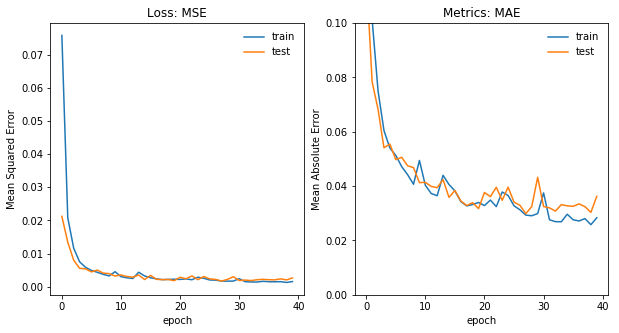

Minimum val loss: 0.00171
Minimum val metrics: 0.02987
------------------------------------------------------------------------------------------
lstm: elapsed_time:196.04686617851257[sec]


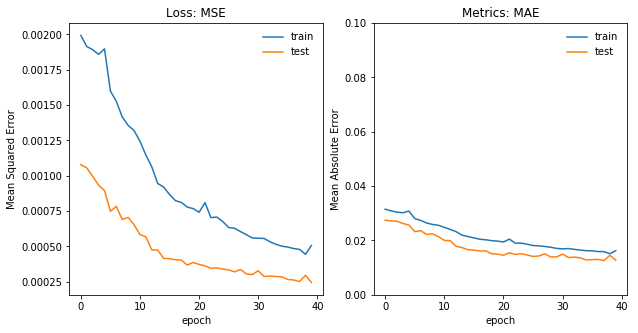

Minimum val loss: 0.00024
Minimum val metrics: 0.01256
------------------------------------------------------------------------------------------
cnn+lstm: elapsed_time:133.61206912994385[sec]


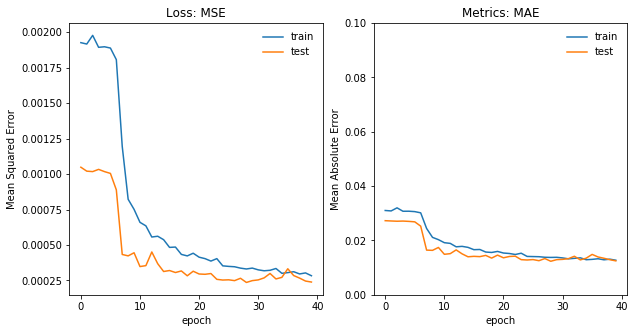

Minimum val loss: 0.00024
Minimum val metrics: 0.01234
------------------------------------------------------------------------------------------


In [292]:
# visualize learning curve
history_dict = {'rnn':hist_rnn, 'lstm':hist_lstm, 'cnn+lstm':hist_cnn_lstm}
elapsed_time_dict = {'rnn':elapsed_time_rnn, 'lstm':elapsed_time_lstm, 'cnn+lstm':elapsed_time_cnn_lstm}
for key, hist_value in history_dict.items():
    print(key+": elapsed_time:{0}".format(elapsed_time_dict[key]) + "[sec]")
    fig = plt.figure(i, figsize=(10,5))

    # loss: mse
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), hist_value.history['loss'], label='train')
    plt.plot(range(num_epochs), hist_value.history['val_loss'], label='test')
    plt.legend(frameon=False)
    plt.xlabel('epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Loss: MSE')

    # metrics: mae
    plt.subplot(1, 2, 2)
    plt.ylim(0., .1)
    plt.plot(range(num_epochs), hist_value.history['mean_absolute_error'], label='train')
    plt.plot(range(num_epochs), hist_value.history['val_mean_absolute_error'], label='test')
    plt.legend(frameon=False)
    plt.xlabel('epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Metrics: MAE')

    plt.show()

    print('Minimum val loss: {:.5f}'.format(np.min(hist_value.history['val_loss'])))
    print('Minimum val metrics: {:.5f}'.format(np.min(hist_value.history['val_mean_absolute_error'])))
    print('---'*30)

---
# <u>#4. Results</u>
### 4-1. Model Evaluation and Validation
The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.
### 4-2. Justification
The final results are compared to the benchmark result or threshold with some type of statistical analysis. Justification is made as to whether the final model and solution is significant enough to have adequately solved the problem.

---
# <u>#5. Conclusion</u>
### 5-1. Free-Form Visualization
A visualization has been provided that emphasizes an important quality about the project with thorough discussion. Visual cues are clearly defined.
### 5-2. Reflection
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.
### 5-3. Improvement
Discussion is made as to how one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.

I appreciate your spending time on my papaer.  
Sincerely,  
[Masaharu Kinoshita](https://www.linkedin.com/in/masaharu-kinoshita/), a newly-fladged data scientist at IBM Japan